<a href="https://colab.research.google.com/github/SaiTanooj/Text-Summarization/blob/main/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional,Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("drive/MyDrive/Reviews.csv",nrows=100000)


In [ ]:
df.shape

(100000, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             99994 non-null   object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 99998 non-null   object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [ ]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               6
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64

In [ ]:
df=df.dropna()

In [ ]:

df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [ ]:

df.shape

(99992, 10)

In [ ]:
df.drop_duplicates(subset=["Text"],inplace=True)

In [ ]:
df.shape

(88419, 10)

In [ ]:

df["Text"].head(10)

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: Text, dtype: object

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
stop_words = set(stopwords.words('english'))
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t))

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
cleaned_text

NameError: name 'cleaned_text' is not defined

In [ ]:
df.loc[:10,"Summary"]

0                             Good Quality Dog Food
1                                 Not as Advertised
2                             "Delight" says it all
3                                    Cough Medicine
4                                       Great taffy
5                                        Nice Taffy
6     Great!  Just as good as the expensive brands!
7                            Wonderful, tasty taffy
8                                        Yay Barley
9                                  Healthy Dog Food
10                  The Best Hot Sauce in the World
Name: Summary, dtype: object

In [ ]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

#Call the above function
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [ ]:
cleaned_summary

['good quality dog food ',
 'not as advertised ',
 'delight says it all ',
 'cough medicine ',
 'great taffy ',
 'nice taffy ',
 'great just as good as the expensive brands ',
 'wonderful tasty taffy ',
 'yay barley ',
 'healthy dog food ',
 'the best hot sauce in the world ',
 'my cats love this diet food better than their regular food ',
 'my cats are not fans of the new food ',
 'fresh and greasy ',
 'strawberry twizzlers yummy ',
 'lots of twizzlers just what you expect ',
 'poor taste ',
 'love it ',
 'great sweet candy ',
 'home delivered twizlers ',
 'always fresh ',
 'twizzlers ',
 'delicious product ',
 'twizzlers ',
 'please sell these in mexico ',
 'twizzlers strawberry ',
 'nasty no flavor ',
 'great bargain for the price ',
 'yummy ',
 'great machine ',
 'this is my taste ',
 'best of the instant oatmeals ',
 'good instant ',
 'great irish oatmeal for those in hurry ',
 'satisfying ',
 'love gluten free oatmeal ',
 'it is oatmeal ',
 'good way to start the day ',
 'wife fa

In [ ]:
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary
df['cleaned_summary'].replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

In [ ]:

df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [ ]:
df.loc[:10,"cleaned_summary"]

0                  _START_ good quality dog food  _END_
1                      _START_ not as advertised  _END_
2                    _START_ delight says it all  _END_
3                         _START_ cough medicine  _END_
4                            _START_ great taffy  _END_
5                             _START_ nice taffy  _END_
6     _START_ great just as good as the expensive br...
7                  _START_ wonderful tasty taffy  _END_
8                             _START_ yay barley  _END_
9                       _START_ healthy dog food  _END_
10       _START_ the best hot sauce in the world  _END_
Name: cleaned_summary, dtype: object

In [ ]:
for i in range(5):
    print("Review:",df['cleaned_text'][i])
    print("Summary:",df['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

In [ ]:
review_word_count=[]
summary_word_count=[]
for i in df['cleaned_text']:
      review_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))
len_df=pd.DataFrame({'review_word_count':review_word_count,'summary_word_count':summary_word_count})

In [ ]:
len_df.head()

,review_word_count,summary_word_count
0,23,6
1,18,5
2,39,6
3,17,4
4,13,4


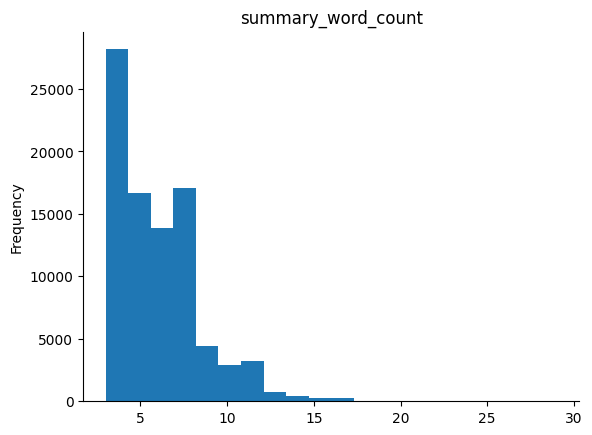

In [ ]:
# @title summary_word_count

from matplotlib import pyplot as plt
len_df['summary_word_count'].plot(kind='hist', bins=20, title='summary_word_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

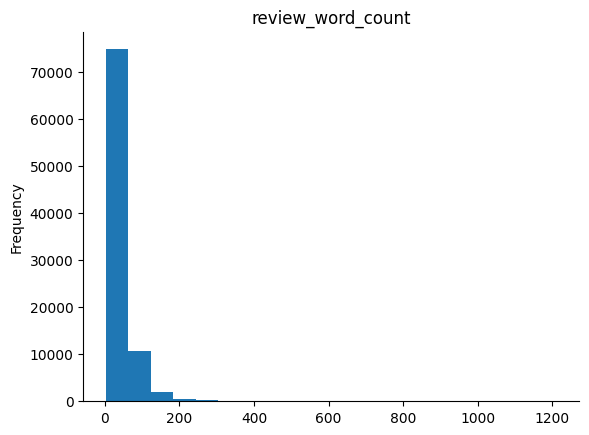

In [ ]:
# @title review_word_count

from matplotlib import pyplot as plt
len_df['review_word_count'].plot(kind='hist', bins=20, title='review_word_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

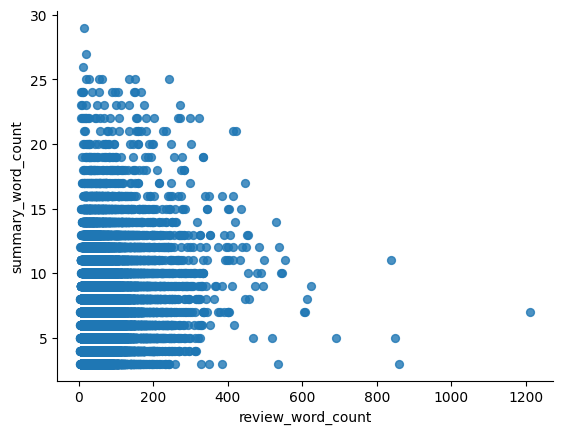

In [ ]:
# @title review_word_count vs summary_word_count

from matplotlib import pyplot as plt
len_df.plot(kind='scatter', x='review_word_count', y='summary_word_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
len_df[len_df["review_word_count"]==len_df["review_word_count"].max()]

,review_word_count,summary_word_count
61937,1212,7


In [ ]:
len_df[len_df["summary_word_count"]==len_df["summary_word_count"].max()]

,review_word_count,summary_word_count
80490,13,29


In [ ]:
max_len_text=80
max_len_summary=10

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88350 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88350 non-null  int64 
 1   ProductId               88350 non-null  object
 2   UserId                  88350 non-null  object
 3   ProfileName             88350 non-null  object
 4   HelpfulnessNumerator    88350 non-null  int64 
 5   HelpfulnessDenominator  88350 non-null  int64 
 6   Score                   88350 non-null  int64 
 7   Time                    88350 non-null  int64 
 8   Summary                 88350 non-null  object
 9   Text                    88350 non-null  object
 10  cleaned_text            88350 non-null  object
 11  cleaned_summary         88350 non-null  object
dtypes: int64(5), object(7)
memory usage: 10.8+ MB


In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(df['cleaned_text'],df['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [ ]:
x_tr.shape


(79515,)

In [ ]:
y_tr.shape

(79515,)

In [ ]:
x_val.shape

(8835,)

In [ ]:
x_tokenizer=Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))
x_tr=x_tokenizer.texts_to_sequences(x_tr)
x_val=x_tokenizer.texts_to_sequences(x_val)
x_tr=pad_sequences(x_tr,maxlen=max_len_text)
x_val=pad_sequences(x_val,maxlen=max_len_text)

x_voc_size=len(x_tokenizer.word_index)+1

In [ ]:
y_tokenizer=Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))
y_tr=y_tokenizer.texts_to_sequences(y_tr)
y_val=y_tokenizer.texts_to_sequences(y_val)
y_tr=pad_sequences(y_tr,maxlen=max_len_summary,padding='post')
y_val=pad_sequences(y_val,maxlen=max_len_summary,padding='post')
y_voc_size=len(y_tokenizer.word_index)+1

In [ ]:
##Encoder design

In [ ]:
latent_dim = 500

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs)

#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#LSTM 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention Layer
attn_layer = Attention(name='attention_layer')
attn_out= attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 80, 500)              2588650   ['input_9[0][0]']             
                                                          0                                       
                                                                                                  
 lstm_16 (LSTM)              [(None, 80, 500),            2002000   ['embedding_8[0][0]']         
                              (None, 500),                                                        
                              (None, 500)]                                                  